In [1]:
import numpy as np
import pandas as pd
import sys
import os
import csv
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
sys.path.append('../modules/')

from genopt.environment import Environment
from genopt.parameters import Parameters
from strategy_controller.create_folds import create_folds_and_interval_df

# DEFINE STRATEGY FUNCTIONS

In [2]:
def read_crypto_data(ticker):
    df = pd.read_csv(f'../data/validation/{ticker}_1_MIN_INTERVAL.csv', parse_dates=['Time'])
    df.columns = ['TIME', 'CLOSE']

    return df

In [3]:
def derivatives(x, y):
    # loess denoising---------
    lowess = sm.nonparametric.lowess
    result = lowess(y, x, 1/20, is_sorted = True) # the smaller the third parameter, the smoothest the fit
    #-------------------------
    
    # derivation calculation----------
    dx = np.gradient(x)
    dy = np.gradient(result[:,1])
    dy_second = np.gradient(dy)
    first_derivative = dy/dx
    second_derivative = dy_second/dx
    
    y = y/np.max(y)
    first_derivative = first_derivative/np.max(first_derivative)
    second_derivative = second_derivative/np.max(second_derivative)
    #----------------------------------
    
    #df generation----------
    data_matrix = np.stack((y,first_derivative, second_derivative), axis = 1)
    df = pd.DataFrame(data_matrix, columns = ['y', 'first_derivative', 'second_derivative'])
    #-----------------------
    
    # std condition inserted to the df-----------
    std_second = np.std(second_derivative)
    mean_second = np.mean(second_derivative)
    lower_bound = mean_second - 7 * std_second
    upper_bound = mean_second + 7 * std_second
    
    condition_second_derivative_is_outlier = ((df['second_derivative'] <= lower_bound) |
                                              (df['second_derivative'] >= upper_bound))
    
    df.loc[condition_second_derivative_is_outlier, 'outlier'] = True
    condition_is_outlier = (df['outlier'] == True)
    #--------------------------------------------
    
    # interpolation---------------------------
    df.loc[condition_is_outlier, 'first_derivative'] = np.nan
    df.loc[condition_is_outlier, 'second_derivative'] = np.nan
    df = df.interpolate(method = 'quadratic')
    
    df.drop('outlier', axis=1, inplace=True)

    
    return df

In [4]:
def apply_strategy(ticker, interval, take_profit, stop_loss, months_validation,
                   velocity_up, velocity_down, acceleration_up, acceleration_down, binance_fee=0.001):
    results_path = '../outputs/strategy_optimization_folds.csv'
    field_names = [
        'TICKER', 'FOLD', 'INTERVAL', 'TAKE_PROFIT', 'STOP_LOSS', 'MONTHS_VALIDATION', 'VELOCITY_UP',
        'VELOCITY_DOWN', 'ACCELERATION_UP', 'ACCELERATION_DOWN', 'ACCUMULATED_INVESTMENT', 'NUM_TRANSACTIONS',
        'ROI'
    ]
    df = read_crypto_data(ticker)
    train_folds, test_folds = create_folds_and_interval_df(df=df, interval=interval, months=months_validation)
    rois = list()
    for fold, fold_idx in enumerate(train_folds):
        df_fold = df.iloc[fold_idx,:]
        x = np.arange(0, df_fold.shape[0])
        y = df_fold['CLOSE'].to_numpy()
        df_fold = derivatives(x, y)
        current_state = None
        buy_price = None
        accumulated_investment = 1
        accumulated_pct_change = 0
        num_transactions = 0
        investment_progress = list()
        df_fold['pct_change'] = df_fold['y'].pct_change()
        for i, row in df_fold.iterrows():
            investment_progress.append(accumulated_investment)
            buy_condition = (
                (
                    (row['first_derivative'] > velocity_down and row['first_derivative'] < velocity_up) and
                    (row['second_derivative'] >= acceleration_up)
                )
            )
            sell_condition = (
                (
                    (row['first_derivative'] > velocity_down and row['first_derivative'] < velocity_up) and
                    (row['second_derivative'] <= acceleration_down)
                )
            )
            current_price = row['y']
            pct_change = row['pct_change']
            if current_state == 1:
                accumulated_investment *= (1 + pct_change)
                accumulated_pct_change += pct_change
                
            if buy_condition:
                if current_state == -1 or current_state == None:
                    current_state = 1
                    accumulated_investment *= (1 - binance_fee)
                    num_transactions += 1
            elif sell_condition or accumulated_pct_change >= take_profit or accumulated_pct_change <= stop_loss:
                if current_state == 1:
                    current_state = -1
                    accumulated_investment *= (1 - binance_fee)
                    accumulated_pct_change = 0
                    num_transactions += 1
        
        roi = (accumulated_investment - 1) * 100
        rois.append(roi)
        dict_row = {
            'TICKER': ticker,
            'FOLD': fold,
            'INTERVAL': interval,
            'TAKE_PROFIT': take_profit,
            'STOP_LOSS': stop_loss,
            'MONTHS_VALIDATION': months_validation,
            'VELOCITY_UP': velocity_up,
            'VELOCITY_DOWN': velocity_down,
            'ACCELERATION_UP': acceleration_up,
            'ACCELERATION_DOWN': acceleration_down,
            'ACCUMULATED_INVESTMENT': accumulated_investment,
            'NUM_TRANSACTIONS': num_transactions,
            'ROI': roi
        }
        if not os.path.exists(results_path):
            df_results = pd.DataFrame(columns=field_names)
            df_results.to_csv(results_path, index=False)
        else:
            with open(results_path, mode='a') as csv_file:
                dict_object = csv.DictWriter(csv_file, fieldnames=field_names)
                dict_object.writerow(dict_row)
        
    return np.mean(rois)

# GENETIC OPTIMIZATION

In [5]:
params = {
    'interval': Parameters.suggest_categorical(['5M', '15M', '30M', '1H', '2H', '4H', '6H', '12H']),
    'take_profit': Parameters.suggest_float(0.005, 0.1),
    'stop_loss': Parameters.suggest_float(0.005, 0.1),
    'velocity_up': Parameters.suggest_float(0.01,1.0),
    'velocity_down': Parameters.suggest_float(-0.01,-1.0),
    'acceleration_up': Parameters.suggest_float(0.01,1.0),
    'acceleration_down': Parameters.suggest_float(-0.01,-1.0)
}

def objective(individual):
    interval = individual['interval']
    take_profit = individual['take_profit']
    stop_loss = individual['stop_loss']
    velocity_up = individual['velocity_up']
    velocity_down = individual['velocity_down']
    acceleration_up = individual['acceleration_up']
    acceleration_down = individual['acceleration_down']
    
    ticker = 'BTCEUR'
    months_validation = 3
    mean_rois = apply_strategy(ticker, interval, take_profit, stop_loss, months_validation,
                                   velocity_up, velocity_down, acceleration_up, acceleration_down)
    
    return mean_rois

environment = Environment(
    params=params,
    num_population=100,
    selection_type='ranking',
    selection_rate=0.8,
    crossover_type='two-point',
    mutation_type='single-gene',
    prob_mutation=0.25,
    verbose=1,
    random_state=42
)

results = environment.optimize(
    objective=objective,
    direction='maximize',
    num_generations=99999,
    timeout=1500,
    n_jobs=-1
)

2022-09-08 10:57:08,239 - INFO - THE BEST SOLUTION IN GENERATION 1 IS {'interval': '12H', 'take_profit': 0.022118596642174054, 'stop_loss': 0.014332324257962648, 'velocity_up': 0.805482927350585, 'velocity_down': -0.13081018937863018, 'acceleration_up': 0.059984054968283844, 'acceleration_down': -0.6312117060664366} WITH A SCORE OF 44.899435631831395
2022-09-08 11:00:57,047 - INFO - THE BEST SOLUTION IN GENERATION 2 IS {'interval': '12H', 'take_profit': 0.04929406174514436, 'stop_loss': 0.014332324257962648, 'velocity_up': 0.805482927350585, 'velocity_down': -0.13081018937863018, 'acceleration_up': 0.059984054968283844, 'acceleration_down': -0.6312117060664366} WITH A SCORE OF 55.09220710828839
2022-09-08 11:04:00,105 - INFO - THE BEST SOLUTION IN GENERATION 3 IS {'interval': '12H', 'take_profit': 0.05681120651573874, 'stop_loss': 0.013379161860037715, 'velocity_up': 0.805482927350585, 'velocity_down': -0.13081018937863018, 'acceleration_up': 0.059984054968283844, 'acceleration_down': 

In [7]:
print(f'EXECUTION TIME={results.execution_time}')
print(f'BEST SCORE={results.best_score}')
print(f'BEST INDIVIDUAL={results.best_individual}')
print('BEST PER GENERATION:')
display(results.best_per_generation_dataframe)
print('LAST GENERATION INDIVIDUALS:')
display(results.last_generation_individuals_dataframe)

EXECUTION TIME=0 hours 27 minutes 58.697094 seconds
BEST SCORE=72.66008955773721
BEST INDIVIDUAL={'interval': '12H', 'take_profit': 0.02027219012458928, 'stop_loss': 0.005785203304856548, 'velocity_up': 0.8390977944225868, 'velocity_down': -0.013109496987640894, 'acceleration_up': 0.028174800159231718, 'acceleration_down': -0.6574542792060458}
BEST PER GENERATION:


,generation,best_score,interval,take_profit,stop_loss,velocity_up,velocity_down,acceleration_up,acceleration_down
0,4,72.660090,12H,0.020272,0.005785,0.839098,-0.013109,0.028175,-0.657454
0,5,72.660090,12H,0.020272,0.005785,0.839098,-0.013109,0.028175,-0.657454
0,6,72.660090,12H,0.020272,0.005785,0.839098,-0.013109,0.028175,-0.657454
0,7,72.660090,12H,0.020272,0.005785,0.839098,-0.013109,0.028175,-0.657454
0,3,56.711512,12H,0.056811,0.013379,0.805483,-0.130810,0.059984,-0.631212
0,2,55.092207,12H,0.049294,0.014332,0.805483,-0.130810,0.059984,-0.631212
0,1,44.899436,12H,0.022119,0.014332,0.805483,-0.130810,0.059984,-0.631212


LAST GENERATION INDIVIDUALS:


,generation,best_score,interval,take_profit,stop_loss,velocity_up,velocity_down,acceleration_up,acceleration_down
0,7,72.660090,12H,0.020272,0.005785,0.839098,-0.013109,0.028175,-0.657454
0,7,72.660090,12H,0.020272,0.005785,0.839098,-0.013109,0.028175,-0.657454
0,7,72.660090,12H,0.020272,0.005785,0.839098,-0.013109,0.028175,-0.657454
0,7,72.660090,12H,0.020272,0.005785,0.839098,-0.013109,0.028175,-0.657454
0,7,70.345562,12H,0.020272,0.005785,0.805483,-0.013109,0.028175,-0.657454
...,...,...,...,...,...,...,...,...,...
0,7,-3.016775,6H,0.057507,0.043706,0.396138,-0.811656,0.413522,-0.036190
0,7,-3.267429,5M,0.040681,0.052792,0.086542,-0.685482,0.357992,-0.232511
0,7,-3.364371,5M,0.049825,0.087541,0.420699,-0.539313,0.029993,-0.167012
0,7,-3.646627,12H,0.012257,0.078954,0.079118,-0.561129,0.255397,-0.251011


In [6]:
df_strategy = pd.read_csv('../outputs/strategy_optimization_folds.csv')

In [8]:
df_strategy

,TICKER,FOLD,INTERVAL,TAKE_PROFIT,STOP_LOSS,MONTHS_VALIDATION,VELOCITY_UP,VELOCITY_DOWN,ACCELERATION_UP,ACCELERATION_DOWN,ACCUMULATED_INVESTMENT,NUM_TRANSACTIONS,ROI
0,BTCEUR,0,12H,0.084842,0.091515,3,0.131583,-0.243547,0.173865,-0.194458,0.947873,4,-5.212717
1,BTCEUR,1,12H,0.007108,0.052326,3,0.481449,-0.833058,0.314699,-0.818222,0.954792,14,-4.520784
2,BTCEUR,2,12H,0.007108,0.052326,3,0.481449,-0.833058,0.314699,-0.818222,1.036886,16,3.688648
3,BTCEUR,1,12H,0.084842,0.091515,3,0.131583,-0.243547,0.173865,-0.194458,1.010666,16,1.066588
4,BTCEUR,3,12H,0.007108,0.052326,3,0.481449,-0.833058,0.314699,-0.818222,1.009986,8,0.998584
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6394,BTCEUR,3,12H,0.012257,0.078954,3,0.079118,-0.561129,0.255397,-0.251011,1.037937,6,3.793693
6395,BTCEUR,4,12H,0.012257,0.078954,3,0.079118,-0.561129,0.255397,-0.251011,0.894796,16,-10.520425
6396,BTCEUR,5,12H,0.012257,0.078954,3,0.079118,-0.561129,0.255397,-0.251011,0.910751,26,-8.924886
6397,BTCEUR,6,12H,0.012257,0.078954,3,0.079118,-0.561129,0.255397,-0.251011,0.885343,22,-11.465660


In [9]:
grouped_results = df_strategy.groupby(['TICKER', 'INTERVAL', 'TAKE_PROFIT', 'STOP_LOSS', 'VELOCITY_UP',
                     'VELOCITY_DOWN', 'ACCELERATION_UP', 'ACCELERATION_DOWN']).mean()

In [10]:
grouped_results.sort_values(by='ROI', ascending=False)

FOLD  \
TICKER INTERVAL TAKE_PROFIT STOP_LOSS VELOCITY_UP VELOCITY_DOWN ACCELERATION_UP ACCELERATION_DOWN         
BTCEUR 12H      0.020272    0.005785  0.839098    -0.013109     0.028175        -0.657454           3.5   
                                      0.805483    -0.013109     0.028175        -0.657454           3.5   
                0.049294    0.008823  0.805483    -0.130810     0.059984        -0.631212           3.5   
                0.075094    0.014332  0.805483    -0.130810     0.059984        -0.631212           3.5   
                0.079153    0.050669  0.988636    -0.130810     0.059984        -0.129927           3.5   
...                                                                                                 ...   
       30M      0.022475    0.049140  0.023521    -0.486865     0.065280        -0.977946           3.5   
       5M       0.051319    0.008193  0.072027    -0.907373     0.147853        -0.537096           3.5   
                0.042276    0.043495  0.134269    -0.815480     0.045409        -0.532944           3.5   
       2H       0.048230    0.032612  0.241243    -0.738625     0.017766        -0.543838           3.5   
       1H       0.094945    0.014542  0.164034    -0.960413     0.047406        -0.977856           3.5   

                                                                                                   MONTHS_VALIDATION  \
TICKER INTERVAL TAKE_PROFIT STOP_LOSS VELOCITY_UP VELOCITY_DOWN ACCELERATION_UP ACCELERATION_DOWN                      
BTCEUR 12H      0.020272    0.005785  0.839098    -0.013109     0.028175        -0.657454                        3.0   
                                      0.805483    -0.013109     0.028175        -0.657454                        3.0   
                0.049294    0.008823  0.805483    -0.130810     0.059984        -0.631212                        3.0   
                0.075094    0.014332  0.805483    -0.130810     0.059984        -0.631212                        3.0   
                0.079153    0.050669  0.988636    -0.130810     0.059984        -0.129927                        3.0   
...                                                                                                              ...   
       30M      0.022475    0.049140  0.023521    -0.486865     0.065280        -0.977946                        3.0   
       5M       0.051319    0.008193  0.072027    -0.907373     0.147853        -0.537096                        3.0   
                0.042276    0.043495  0.134269    -0.815480     0.045409        -0.532944                        3.0   
       2H       0.048230    0.032612  0.241243    -0.738625     0.017766        -0.543838                        3.0   
       1H       0.094945    0.014542  0.164034    -0.960413     0.047406        -0.977856                        3.0   

                                                                                                   ACCUMULATED_INVESTMENT  \
TICKER INTERVAL TAKE_PROFIT STOP_LOSS VELOCITY_UP VELOCITY_DOWN ACCELERATION_UP ACCELERATION_DOWN                           
BTCEUR 12H      0.020272    0.005785  0.839098    -0.013109     0.028175        -0.657454                        1.726601   
                                      0.805483    -0.013109     0.028175        -0.657454                        1.703456   
                0.049294    0.008823  0.805483    -0.130810     0.059984        -0.631212                        1.653488   
                0.075094    0.014332  0.805483    -0.130810     0.059984        -0.631212                        1.605315   
                0.079153    0.050669  0.988636    -0.130810     0.059984        -0.129927                        1.594158   
...                                                                                                                   ...   
       30M      0.022475    0.049140  0.023521    -0.486865     0.065280        -0.977946                        0.893493   
       5M       0.051

# PLOT STRATEGY TRAIN

In [11]:
def plot_strategy_training(ticker, interval, take_profit, stop_loss, months_validation,
                   velocity_up, velocity_down, acceleration_up, acceleration_down, binance_fee=0.001):
    df = read_crypto_data(ticker)
    folds = create_folds_and_interval_df(df=df, interval=interval, months=months_validation)
    test_idx = folds[-1].copy()
    folds = folds[:-1].copy()
    df_test = df.iloc[test_idx,:]
    rois = list()
    for fold, fold_idx in enumerate(folds):
        df_fold = df.iloc[fold_idx,:]
        x = np.arange(0, df_fold.shape[0])
        y = df_fold['CLOSE'].to_numpy()
        df_fold = derivatives(x, y)
        current_state = None
        buy_price = None
        accumulated_investment = 1
        accumulated_pct_change = 0
        num_transactions = 0
        investment_progress = list()
        df_fold['pct_change'] = df_fold['y'].pct_change()
        for i, row in df_fold.iterrows():
            investment_progress.append(accumulated_investment)
            buy_condition = (
                (
                    (row['first_derivative'] > velocity_down and row['first_derivative'] < velocity_up) and
                    (row['second_derivative'] >= acceleration_up)
                )
            )
            sell_condition = (
                (
                    (row['first_derivative'] > velocity_down and row['first_derivative'] < velocity_up) and
                    (row['second_derivative'] <= acceleration_down)
                )
            )
            current_price = row['y']
            pct_change = row['pct_change']
            if current_state == 1:
                accumulated_investment *= (1 + pct_change)
                accumulated_pct_change += pct_change
                
            if buy_condition:
                if current_state == -1 or current_state == None:
                    current_state = 1
                    accumulated_investment *= (1 - binance_fee)
                    num_transactions += 1
            elif sell_condition or accumulated_pct_change >= take_profit or accumulated_pct_change <= stop_loss:
                if current_state == 1:
                    current_state = -1
                    accumulated_investment *= (1 - binance_fee)
                    accumulated_pct_change = 0
                    num_transactions += 1
        
        df_fold['time'] = df_fold.index
        df_fold['accum'] = investment_progress
        ax = df_fold.plot(x='time', y='y', legend=False, figsize=(20,10))
        ax2 = ax.twinx()
        df_fold.plot(x='time', y='accum', ax=ax2, legend=False, color='red', figsize=(20,10))
        ax.figure.legend(['TRUTH', 'ACCUMULATED INVESTMENT'], fontsize=18)
        plt.show()
        
    return np.mean(rois)

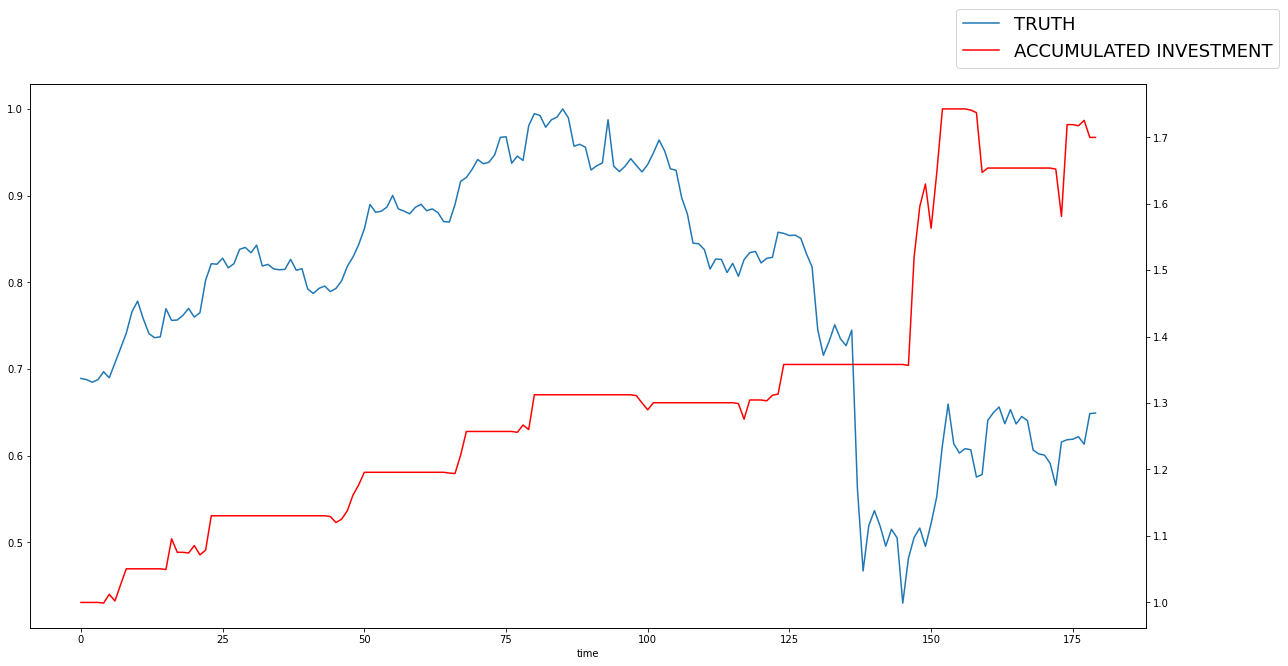

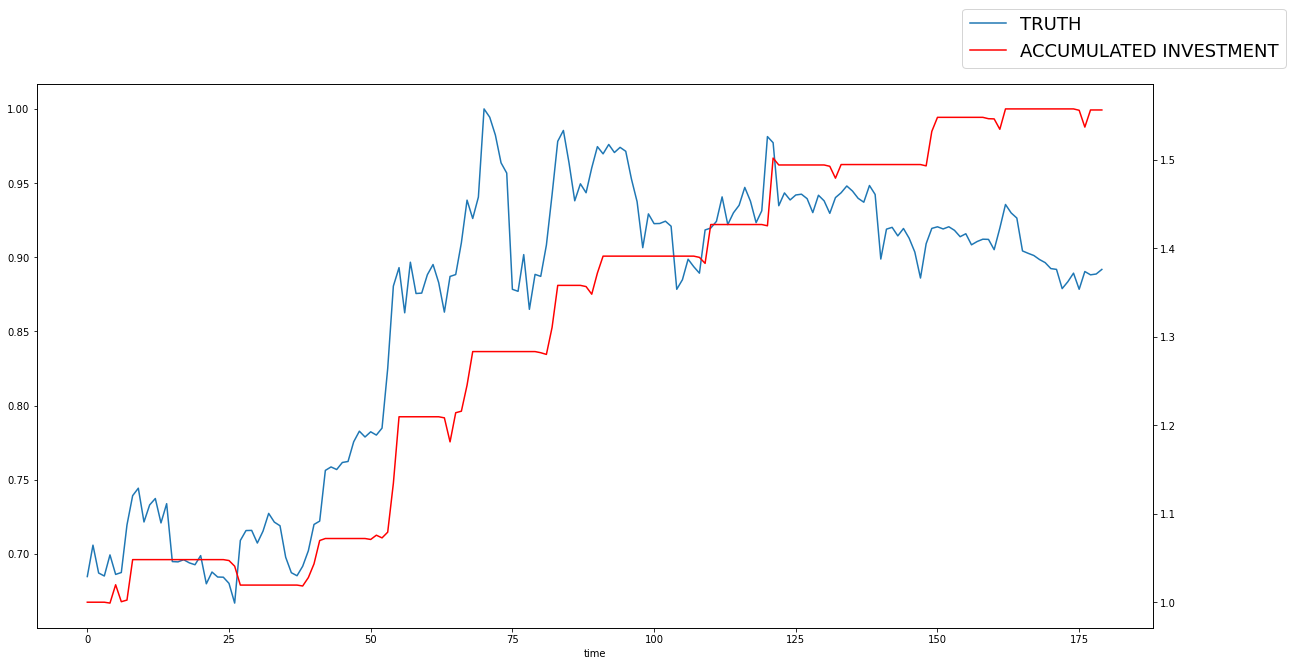

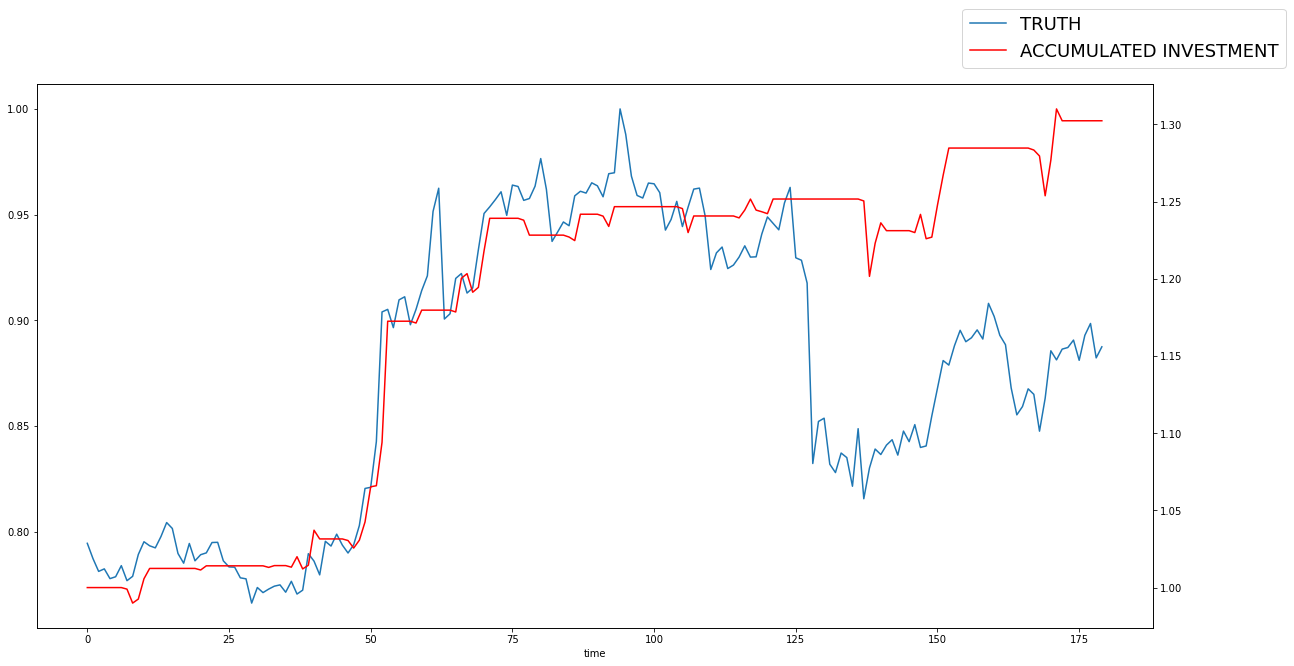

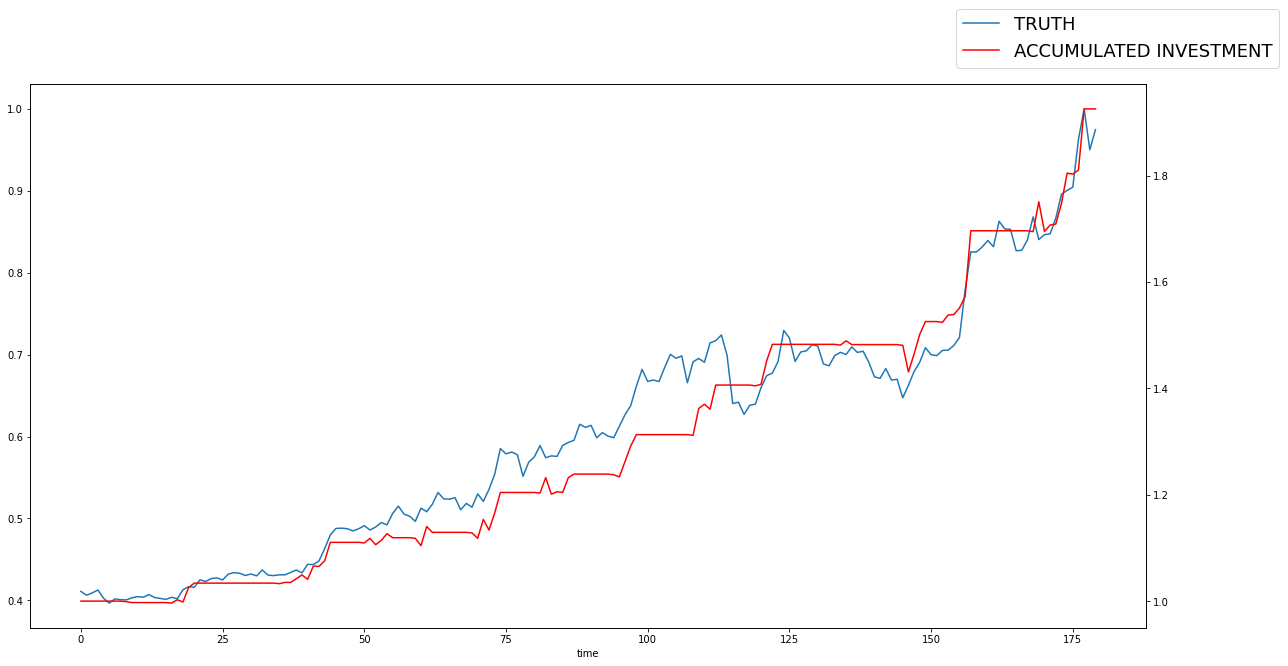

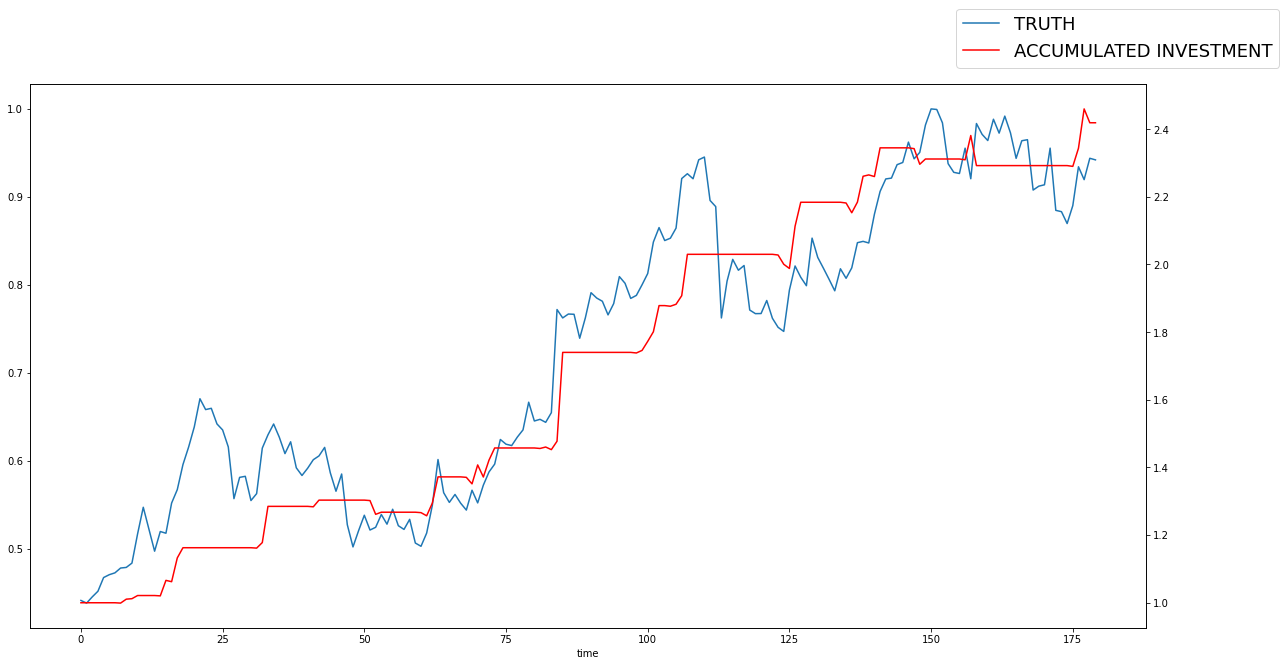

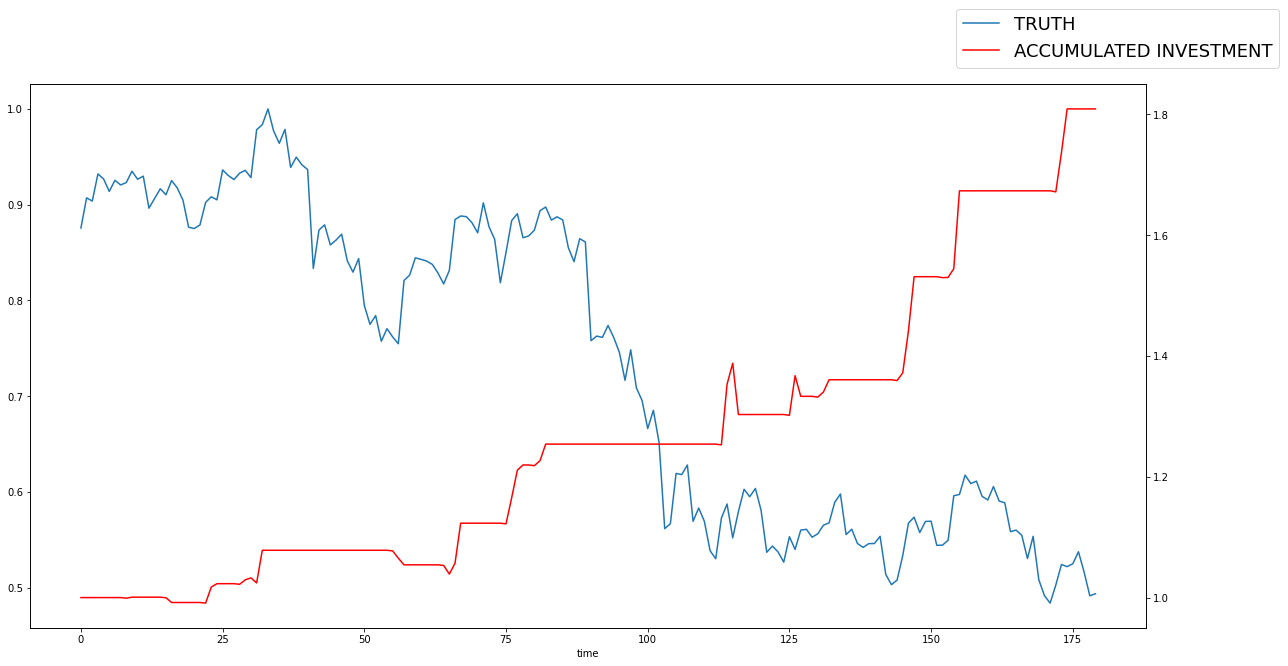

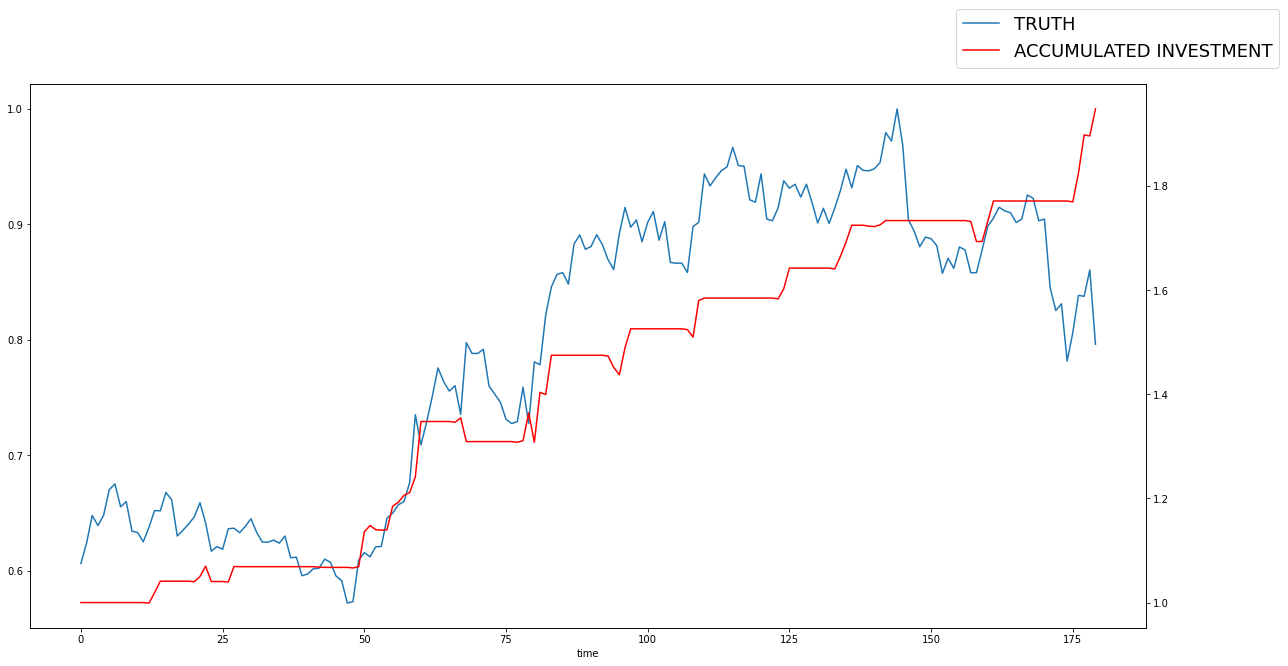

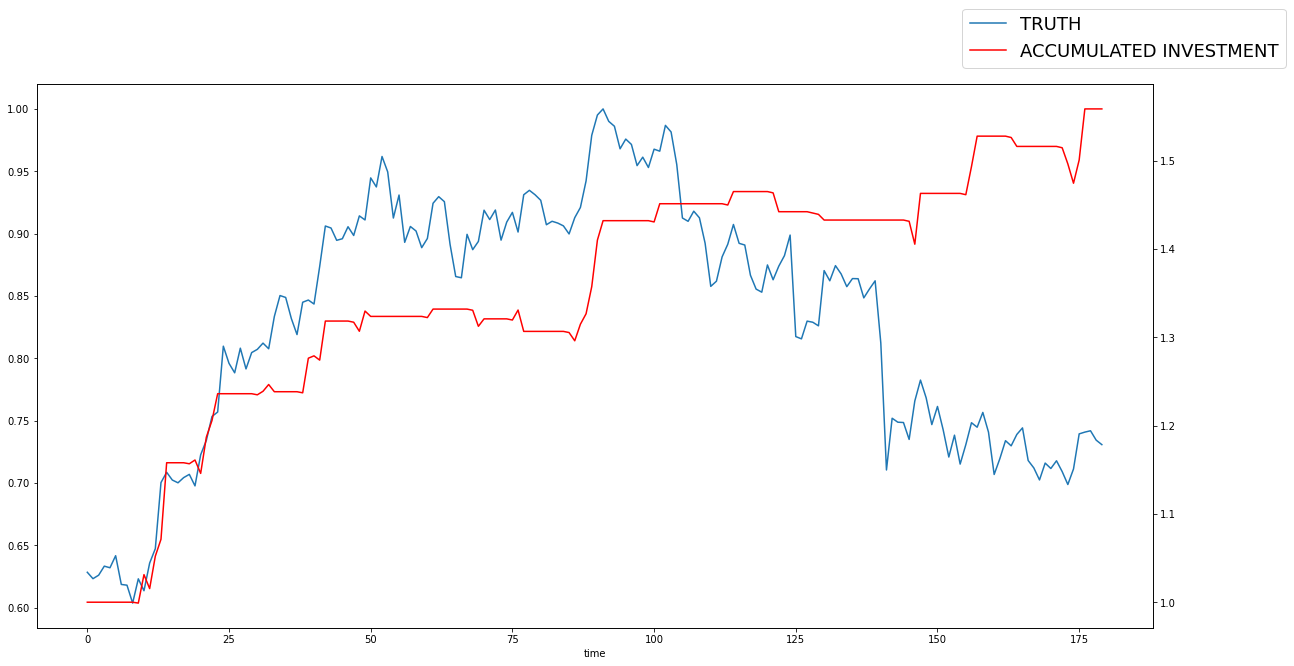

nan

In [75]:
plot_strategy_training(ticker='BTCEUR', interval='12H', take_profit=0.09037235645667234, stop_loss=0.005785203304856548,
              months_validation=3, velocity_up=0.8390977944225868, velocity_down=-0.013109496987640894,
              acceleration_up=0.028174800159231718, acceleration_down=0.6574542792060458)

# TEST STRATEGY IN TESTING

In [70]:
def plot_strategy_testing(ticker, interval, take_profit, stop_loss, months_validation,
                   velocity_up, velocity_down, acceleration_up, acceleration_down, binance_fee=0.001):
    df = read_crypto_data(ticker)
    folds = create_folds_and_interval_df(df=df, interval=interval, months=months_validation)
    test_idx = folds[-1].copy()
    folds = folds[:-1].copy()
    df_test = df.iloc[test_idx,:]
    rois = list()
    
    df_fold = df_test.copy()
    x = np.arange(0, df_fold.shape[0])
    y = df_fold['CLOSE'].to_numpy()
    df_fold = derivatives(x, y)
    current_state = None
    buy_price = None
    accumulated_investment = 1
    accumulated_pct_change = 0
    num_transactions = 0
    investment_progress = list()
    df_fold['pct_change'] = df_fold['y'].pct_change()
    for i, row in df_fold.iterrows():
        investment_progress.append(accumulated_investment)
        buy_condition = (
            (
                (row['first_derivative'] > velocity_down and row['first_derivative'] < velocity_up) and
                (row['second_derivative'] >= acceleration_up)
            )
        )
        sell_condition = (
            (
                (row['first_derivative'] > velocity_down and row['first_derivative'] < velocity_up) and
                (row['second_derivative'] <= acceleration_down)
            )
        )
        current_price = row['y']
        pct_change = row['pct_change']
        if current_state == 1:
            accumulated_investment *= (1 + pct_change)
            accumulated_pct_change += pct_change

        if buy_condition:
            if current_state == -1 or current_state == None:
                current_state = 1
                accumulated_investment *= (1 - binance_fee)
                num_transactions += 1
        elif sell_condition or accumulated_pct_change >= take_profit or accumulated_pct_change <= stop_loss:
            if current_state == 1:
                current_state = -1
                accumulated_investment *= (1 - binance_fee)
                accumulated_pct_change = 0
                num_transactions += 1
        
    roi = (accumulated_investment - 1) * 100
    rois.append(roi)
    
    df_test['accum'] = investment_progress
    ax = df_test.plot(x='TIME', y='CLOSE', legend=False, figsize=(20,10))
    ax2 = ax.twinx()
    df_test.plot(x='TIME', y='accum', ax=ax2, legend=False, color='red', figsize=(20,10))
    ax.figure.legend(['TRUTH', 'ACCUMULATED INVESTMENT'], fontsize=18)
    plt.show()
        
    return np.mean(rois)

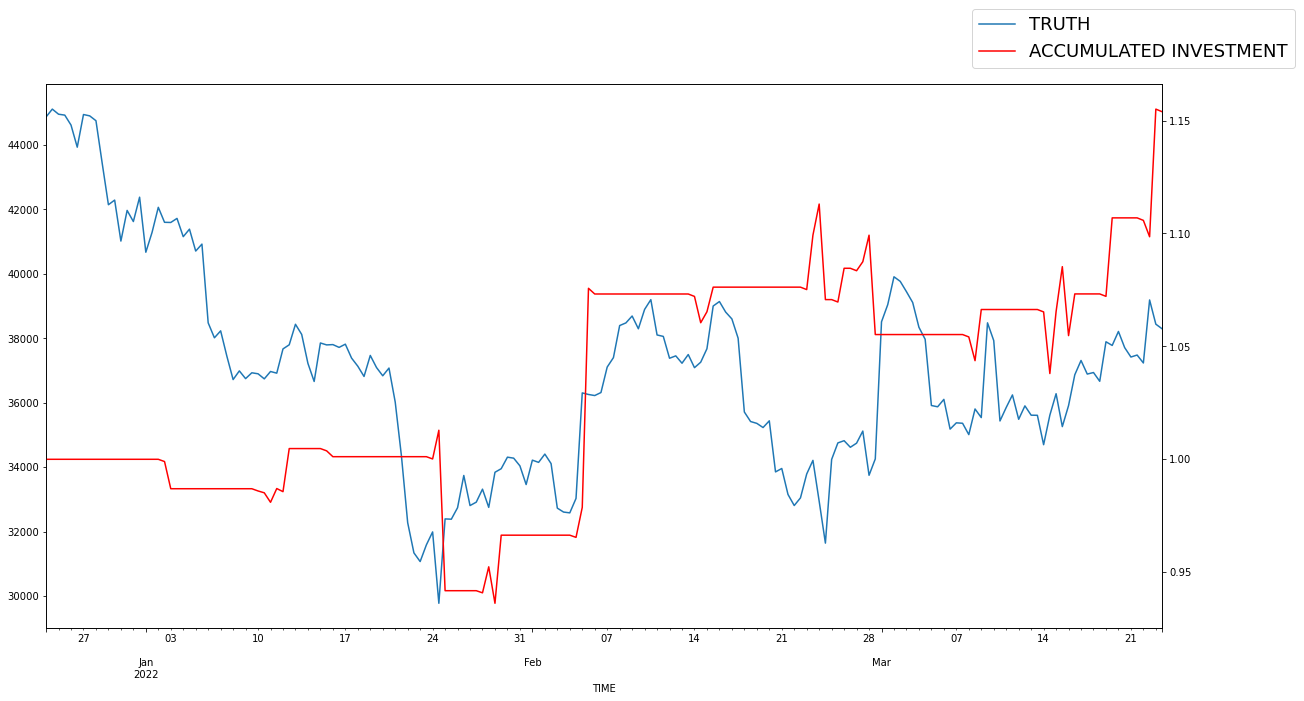

14.850557763016049

In [71]:
plot_strategy_testing(ticker='BTCEUR', interval='12H', take_profit=0.09037235645667234, stop_loss=0.005785203304856548,
              months_validation=3, velocity_up=0.8390977944225868, velocity_down=-0.013109496987640894,
              acceleration_up=0.028174800159231718, acceleration_down=0.6574542792060458)